# 0.0. Imports

In [1]:
import datetime
import inflection

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from scipy                import stats  as ss
from sklearn              import preprocessing as pp

from math                 import isnan
from tabulate             import tabulate
from IPython.core.display import HTML

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k - 1 )*( r - 1 )/( n - 1 ) )

    kcorr = k - ( k - 1 )**2/( n - 1 )
    rcorr = r - ( r - 1 )**2/( n - 1 )

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr - 1, rcorr - 1 ) ) )

In [3]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [4]:
jupyter_settings()

## 0.2. Loading data

In [5]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = list(df1.columns)

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Rows: {df1.shape[1]}' )

Number of Rows: 1017209
Number of Rows: 18


## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [12]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if isnan( x ) else x )

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month 
        if isnan( x['competition_open_since_month'] ) 
        else x['competition_open_since_month'],
    axis=1
)

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply( 
    lambda x: x['date'].year 
        if isnan( x['competition_open_since_year'] ) 
        else x['competition_open_since_year'],
    axis=1
)


# promo2_since_week

df1['promo2_since_week'] = df1.apply( 
    lambda x: x['date'].week 
        if isnan( x['promo2_since_week'] ) 
        else x['promo2_since_week'],
    axis=1
)

# promo2_since_year

df1['promo2_since_year'] = df1.apply( 
    lambda x: x['date'].year
        if isnan( x['promo2_since_year'] ) 
        else x['promo2_since_year'],
    axis=1
)

# promo_interval

month_map = { 1: 'Jan', 2: ' Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
            }

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 
        if x['month_map'] in x['promo_interval'].split( ',' ) else 0,
    axis=1 
)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [18]:
#  Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='competition_distance', ylabel='Count'>

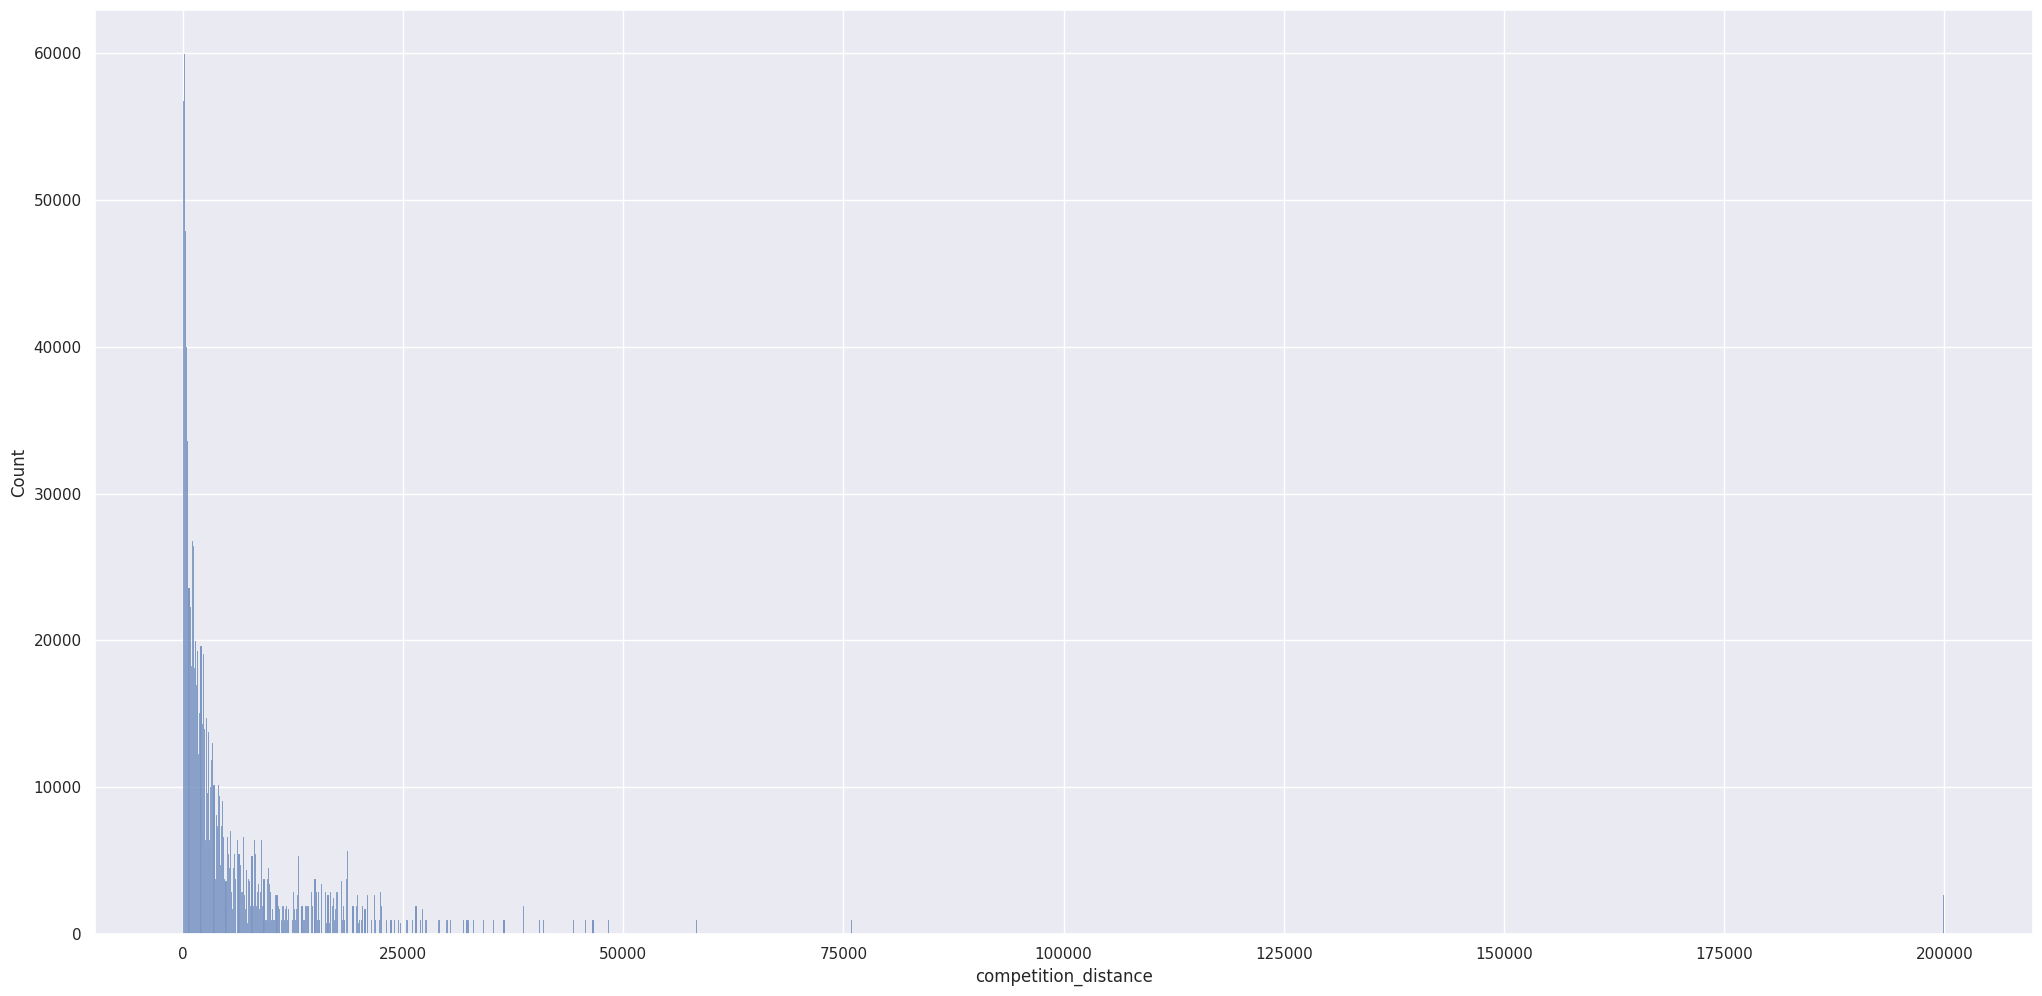

In [19]:
sns.histplot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.nunique() )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

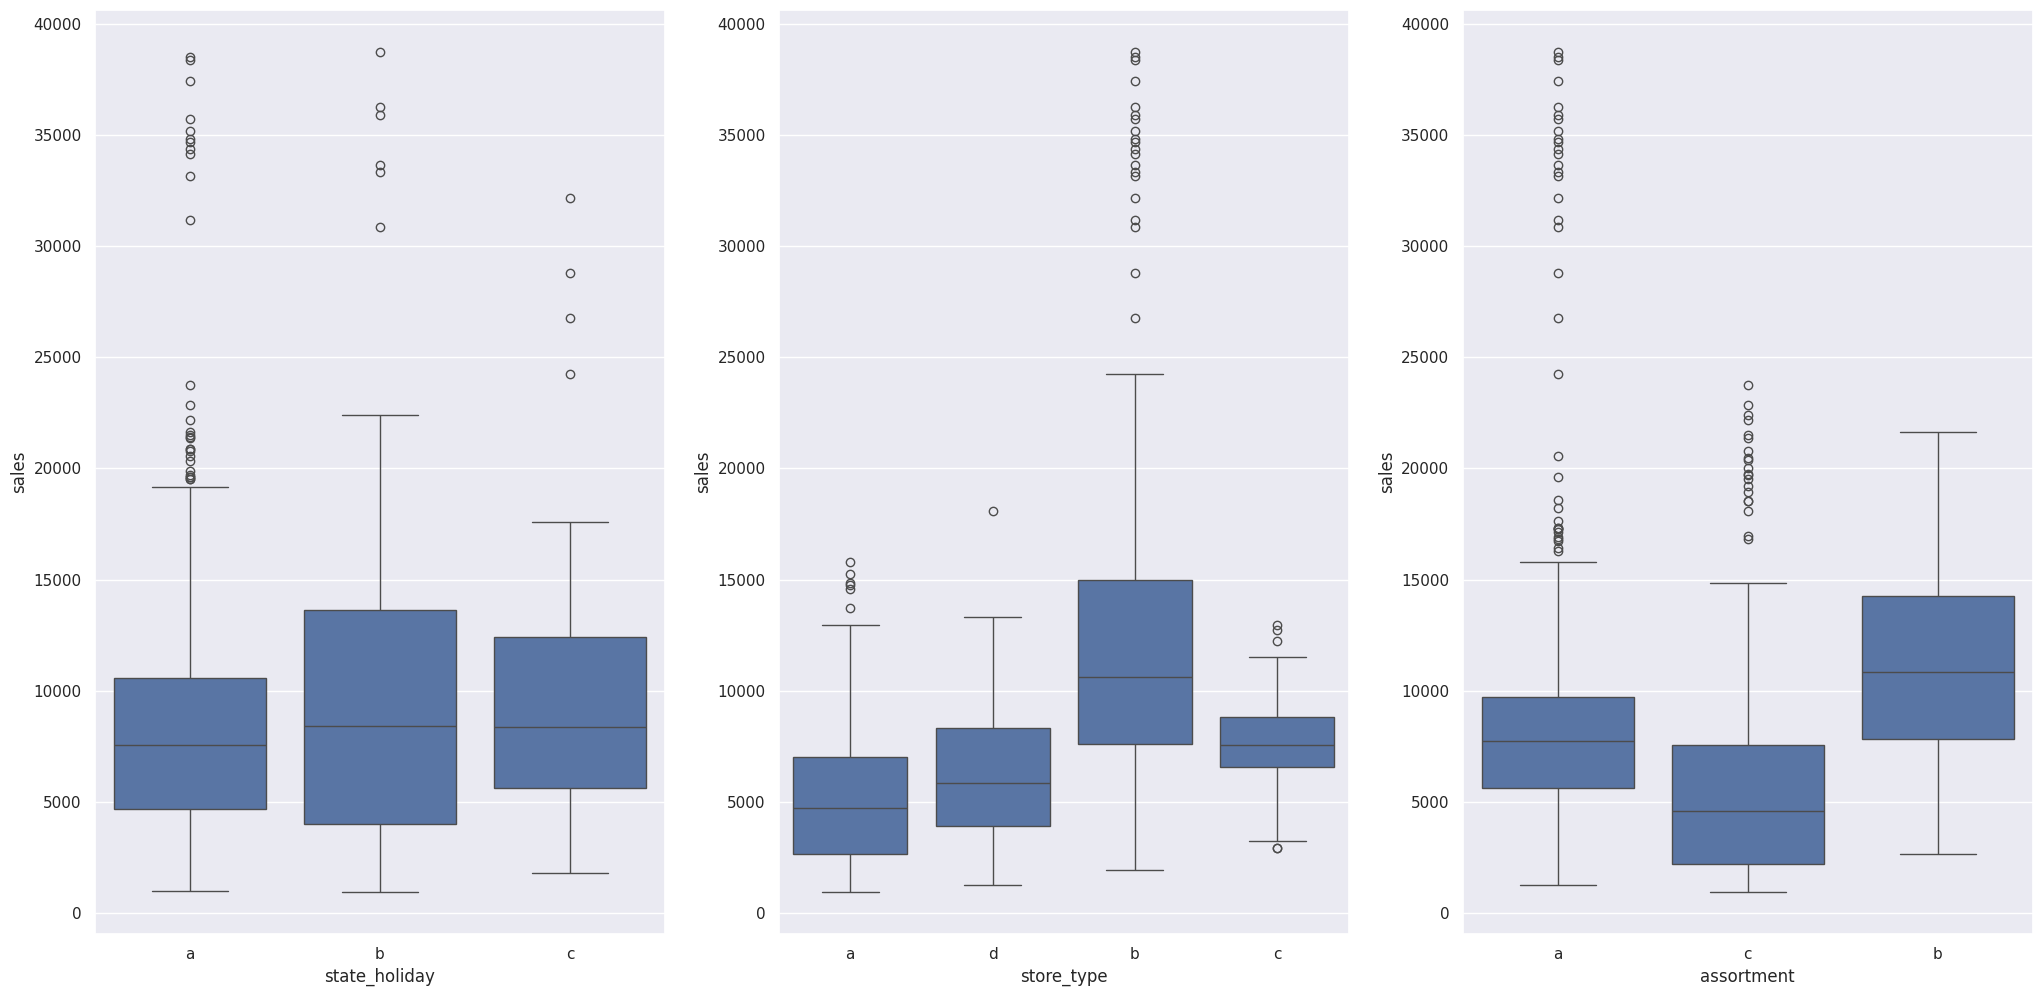

In [21]:
aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]


plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

### 2.1.1. Mapa Mental

![Texto Alternativo](img/Mind_MapHypothesis.png)

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vender menos

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender menos

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante feriados escolares.

## 2.4. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime( 
        year=x['competition_open_since_year'],
        month=x['competition_open_since_month'],
        day=1
    ),
    axis=1
)
df2['competition_time_month'] = ( 
    ( df2['date'] - df2['competition_since'] ) / 30 
    ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment
assortment_map = {
    'a': 'basic',
    'b': 'extra',
    'c': 'extended'
}
df2['assortment'] = df2['assortment'].map(assortment_map)

# state holiday
state_holiday_map = {
    'a': 'public holiday',
    'b': 'Easter holiday',
    'c': 'Christmas',
    '0': 'regular_day'
}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

## 3.1 - Filtragem das Linhas

In [26]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 - Seleção das Colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [29]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

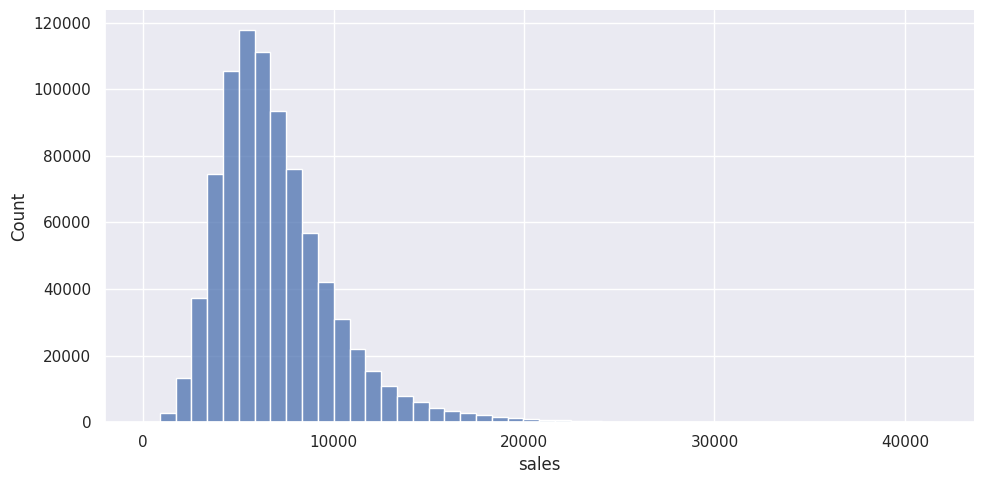

In [30]:
sns.displot( df4['sales'], kde=False, bins=50, aspect=2);

### 4.1.2. Numerical Variable

In [ ]:
num_attributes.hist( bins=25, figsize=(16,12) );

### 4.1.3. Categorical Variable

In [ ]:
fig, axs = plt.subplots(3, 2, sharex=False)

# state_holiday
df_aux = df4[df4['state_holiday'] != 'regular_day']

sns.countplot( data=df_aux, x='state_holiday', hue='state_holiday', palette='Set2', ax=axs[0, 0] )

sns.kdeplot( data=df4[df4['state_holiday'] == 'public holiday'], x='sales', color='#66c2a5', fill=True, label='public holiday', ax=axs[0, 1] )
sns.kdeplot( data=df4[df4['state_holiday'] == 'Easter holiday'], x='sales', color='#fc8d62', fill=True, label='Easter holiday', ax=axs[0, 1] )
sns.kdeplot( data=df4[df4['state_holiday'] == 'Christmas'], x='sales', color='#8da0cb', fill=True, label='Christmas', ax=axs[0, 1] )
axs[0, 1].legend()

# store_type
sns.countplot( data=df4, x='store_type', hue='store_type', palette='Set1', ax=axs[1, 0], order=df4['store_type'].value_counts().index )

sns.kdeplot( data=df4[df4['store_type'] == 'a'], x='sales', color='#377eb8', fill=True, label='a', ax=axs[1, 1])
sns.kdeplot( data=df4[df4['store_type'] == 'b'], x='sales', color='#984ea3', fill=True, label='b', ax=axs[1, 1] )
sns.kdeplot( data=df4[df4['store_type'] == 'c'], x='sales', color='#e41a1c', fill=True, label='c', ax=axs[1, 1] )
sns.kdeplot( data=df4[df4['store_type'] == 'd'], x='sales', color='#4daf4a', fill=True, label='d', ax=axs[1, 1] )
axs[1, 1].legend()

# assortment
sns.countplot( data=df4, x='assortment', hue='assortment', palette='Set3', ax=axs[2, 0], order=df4['assortment'].value_counts().index )

sns.kdeplot( data=df4[df4['assortment'] == 'basic'], x='sales', color='#8dd3c7', fill=True, label='basic', ax=axs[2, 1])
sns.kdeplot( data=df4[df4['assortment'] == 'extended'], x='sales', color='#ffffb3', fill=True, label='extended', ax=axs[2, 1] )
sns.kdeplot( data=df4[df4['assortment'] == 'extra'], x='sales', color='#bebada', fill=True, label='extra', ax=axs[2, 1] )
axs[2, 1].legend()

plt.tight_layout(h_pad=1.8)
plt.show();

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

In [ ]:
fig, axs = plt.subplots( 3, 1, sharex=False )

aux_h1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( data=aux_h1, x='assortment', y='sales', hue='assortment', palette='Set3', ax=axs[0] )

aux2_h1 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2_h1.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3_h1 = aux2_h1[aux2_h1['assortment'] == 'extra']
aux3_h1.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

In [ ]:
df_aux = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list( np.arange( 0, 20000, 250 ) )
df_aux['competition_distance_binned'] = pd.cut( df_aux['competition_distance'], bins=bins )
aux = df_aux[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned', observed=False ).sum().reset_index()

fig, axs = plt.subplots(2, 1, sharex=False)

axs[0].tick_params(axis='x', rotation=90)
sns.barplot( x='competition_distance_binned', y='sales', data=aux, ax=axs[0]);

sns.heatmap( df_aux[['competition_distance', 'sales']].corr( method='pearson' ), annot=True, ax=axs[1] );

fig.subplots_adjust(hspace=0.6)

### H3. Lojas com competidores à mais tempo deveriam vender mais.

**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem menos.

In [ ]:
fig, axs = plt.subplots( 3, 1, sharex=False )


df_aux = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux[ ( df_aux['competition_time_month'] < 100 ) & ( df_aux['competition_time_month'] != 0 ) ]
sns.barplot( data=df_aux2, x='competition_time_month', y='sales', ax=axs[0]);
axs[0].tick_params( 'x', rotation=90 )

sns.regplot( x='competition_time_month', y='sales', data=df_aux2, ax=axs[1] );

sns.heatmap( df_aux2.corr( method='pearson' ), annot=True, ax=axs[2]);

fig.subplots_adjust(hspace=0.5)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

In [ ]:
df_aux = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = plt.GridSpec( 3, 2, hspace=0.5 )

aux_regular = df_aux[( df_aux['promo_time_week'] < 0 )]
aux_extendida = df_aux[( df_aux['promo_time_week'] > 0 ) ]

fig = plt.figure()


ax1 = fig.add_subplot( grid[0, 0] )
sns.barplot( data=aux_regular, x='promo_time_week', y='sales', ax=ax1 );
ticks_loc = ax1.get_xticks()[::10]
ticks_labels = [label.get_text() for label in ax1.get_xticklabels()][::10]
ax1.set_xticks(ticks_loc)
ax1.set_xticklabels(ticks_labels, rotation=90)

ax2 = fig.add_subplot( grid[0, 1] )
sns.regplot( data=aux_regular, x='promo_time_week', y='sales', ax=ax2 );
ax2.tick_params('x', rotation=90)

ax3 = fig.add_subplot( grid[1, 0] )
sns.barplot( data=aux_extendida, x='promo_time_week', y='sales', ax=ax3 );
ticks_loc = ax3.get_xticks()[::10]
ticks_labels = [label.get_text() for label in ax3.get_xticklabels()][::10]
ax3.set_xticks(ticks_loc)
ax3.set_xticklabels(ticks_labels, rotation=90)

ax4 = fig.add_subplot( grid[1, 1] )
sns.regplot( data=aux_extendida, x='promo_time_week', y='sales', ax=ax4 );
ax4.tick_params('x', rotation=90)

ax4 = fig.add_subplot( grid[2, :] )
sns.heatmap( df_aux.corr( method='pearson' ), annot=True );


### H5. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

In [ ]:
aux = df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().sort_values('sales', ascending=False).reset_index()

conditions = [
    (aux['promo'] == 0) & (aux['promo2'] == 0),
    (aux['promo'] == 0) & (aux['promo2'] == 1),
    (aux['promo'] == 1) & (aux['promo2'] == 0),
    (aux['promo'] == 1) & (aux['promo2'] == 1)
]

values = ["Sem promoção", "Extendida", "Tradicional", "Tradicional e Extendida"]

aux['legenda'] = np.select(conditions, values)

aux

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot( figsize=(16,6))

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida'] );

### H6. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado de Natal vendem menos

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

df_aux = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

fig, axs = plt.subplots( 2, 1, sharex=False )

plt.figure( figsize=(16,5));
sns.barplot( data=df_aux, x='state_holiday', y='sales', hue='state_holiday', ax=axs[0] );

aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( data=aux2, x='year', y='sales', hue='state_holiday', ax=axs[1] );

### H7. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo do ano. Mesmo que 2015 não seja um ano fechado, percebe-se uma tendência de queda.

In [ ]:
aux = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index().sort_values('sales', ascending=False)


fig, axs = plt.subplots( 2, 1, sharex=False, figsize=(20,9) )

sns.barplot( data=aux, x='year', y='sales', hue='year', ax=axs[0])

aux2 = df4[['week_of_year', 'sales', 'year']].groupby( ['week_of_year', 'year'] ).sum().reset_index()

sns.lineplot( data=aux2, x='week_of_year', y='sales', hue='year', ax=axs[1] );

##! Adicionar o gráfico de regressão (regplot) e de correlação. Colocar os dois em uma única linha na imagem

### H8. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano

In [ ]:
df_aux = df4[df4['year'] != '2015']

df_aux['semester'] = df_aux.apply( lambda x: 1 if x['month'] <= 6 else 2, axis=1)
df_aux['week_of_semester'] = df_aux['week_of_year'].apply(lambda x: x if x <= 26 else x - 26)

fig, axs = plt.subplots( 2, 1, sharex=False)

aux = df_aux[['semester', 'sales', 'week_of_semester']].groupby( ['semester', 'week_of_semester'] ).sum().reset_index()
sns.barplot( data=aux, x='semester', y='sales', hue='semester', ax=axs[0], width=0.3, palette='Set1' );

sns.lineplot( data=aux, x='week_of_semester', y='sales', hue='semester', ax=axs[1], palette='Set1' );

### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

In [ ]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axs = plt.subplots( 2, 2, sharex=False)

sns.barplot( data=aux1, x='day', y='sales', ax=axs[0, 0] );

sns.regplot( data=aux1, x='day', y='sales', ax=axs[0, 1] );

sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axs[1, 0] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

sns.barplot( data=aux2, x='before_after', y='sales', ax=axs[1, 1] )


### H10. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos nos finais de semana.

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axs = plt.subplots( 1, 3)

sns.barplot( data=aux1, x='day_of_week', y='sales', hue='day_of_week', palette='Set2', ax=axs[0] )

sns.regplot( data=aux1, x='day_of_week', y='sales', ax=axs[1] )

sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axs[2] );

### H11. Lojas deveriam vender menos durante feriados escolares.

**VERDADEIRA** Loja vendem menos durante os feriados escolares, exceto durante os meses de Julho e Agosto.

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axs = plt.subplots( 2, 1 )

sns.barplot( data=aux1, x='school_holiday', y='sales', hue='school_holiday', ax=axs[0] );

aux2 = df4[[ 'month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

sns.barplot( data=aux2, x='month', y='sales', hue='school_holiday', ax=axs[1] );

### 4.2.1. Resumo das Hipóteses

In [ ]:
tab = [
    ['Hipóteses', 'Conclusão', 'Relevância'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Média'],
    ['H3', 'Falsa', 'Média'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', 'Falsa', 'Baixa'],
    ['H6', 'Falsa', 'Média'],
    ['H7', 'Falsa', 'Alta'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Verdadeira', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Baixa']]

In [ ]:
print( tabulate( tab, headers='firstrow' ) )

## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

In [ ]:
correlation = num_attributes.corr( method='pearson' )

sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [ ]:
a = df4.select_dtypes( include='object' )

In [ ]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0. PREPARAÇÃO DOS DADOS

In [ ]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [ ]:
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )

df5['year'] = rs.fit_transform( df5[['year']].values )

## 5.3. Transformação

### 5.3.1. Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int )

# store_type - Label Encoding
le = pp.LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Reponse Variable Transformation

In [ ]:
df5['sales'] = np.log1p( df4['sales'] )

### 5.3.3. Nature Transformation

In [ ]:
df5.dtypes

In [ ]:
# day_of_week
df4['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df4['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df4['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df4['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df4['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df4['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df4['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df4['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [ ]:
df5.head(20)